In [ ]:
import pickle
from config import UNL_FEA_IDX, DATASET_ID


model_types = ['mlp', 'resnet', 'ftformer']

new_TRI_dict, new_EI_dict, new_RASI_dict, new_SDI_dict, new_SRI_dict = {}, {}, {}, {}, {}
for model_type in model_types:
    for metric in ['TRI', 'EI', 'RASI', 'SDI', 'SRI']:
        with open(f'results/{model_type}_{metric}.dict', 'rb') as f:
            if metric == 'TRI': new_TRI_dict[model_type] = pickle.load(f)
            elif metric == 'EI': new_EI_dict[model_type] = pickle.load(f)
            elif metric == 'RASI': new_RASI_dict[model_type] = pickle.load(f)
            elif metric == 'SRI': new_SRI_dict[model_type] = pickle.load(f)
            elif metric == 'SDI': new_SDI_dict[model_type] = pickle.load(f)
    


In [2]:
new_TRI_dict['mlp']['CALI'][0][0]

unl_epoch,1,10,50,100,200,400,600,800,1000,1500
Ours,1.025355,0.990090,1.000811,1.005245,1.002724,1.004173,1.006636,1.006752,1.006491,1.000927
FOUL,0.939728,0.714286,0.843234,0.773109,0.647928,0.731092,0.665894,0.596928,0.596928,0.595769
MIUL,1.051521,1.052449,1.050971,1.049638,1.049899,1.050565,1.049551,1.049957,1.050043,1.049522


### Different Feature Importance Plotting

In [3]:
def plot(metric_dict: dict, y_lim_lb: float, y_lim_ub: float, model_type: str, metric: str):
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    import os

    # Apply a clean style
    plt.style.use('seaborn-v0_8-darkgrid')

    # Define markers, line styles, and colors for consistent styling
    markers = ['o', 's', 'D', '^']
    linestyles = ['-', '--', '-.', ':']
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']  # Custom color palette

    # Get number of features to aggregate
    first_dataset = next(iter(DATASET_ID))
    num_features = len(UNL_FEA_IDX[first_dataset])

    # Set up the plots - one subplot per feature
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    axes = axes.flatten() if num_features > 1 else [axes]

    # For each feature position (sort_idx)
    for sort_idx in range(num_features):
        # Collect all dataframes for this feature position across datasets
        feature_dfs = []
        for dataset_name in DATASET_ID.keys():
            unl_fea_idx = UNL_FEA_IDX[dataset_name][sort_idx]
            if unl_fea_idx in metric_dict[dataset_name]:
                df_means, _ = metric_dict[dataset_name][unl_fea_idx]
                if df_means is not None:
                    feature_dfs.append(df_means)
        
        # Skip if no data
        if not feature_dfs:
            axes[sort_idx].text(0.5, 0.5, "No data available", 
                                ha='center', va='center', transform=axes[sort_idx].transAxes)
            continue
            
        # Get unique methods across all datasets
        all_methods = ['Ours', 'FOUL', 'MIUL']
        # for df in feature_dfs:
        #     all_methods.update(df.index)
        
        # Plot each method separately with consistent styling
        for i, method in enumerate(all_methods):
            # Use modulo to cycle through styling options if more methods than styles
            style_idx = i % len(markers)
            marker = markers[style_idx]
            linestyle = linestyles[style_idx]
            color = colors[style_idx]
            
            # Collect data for this method across datasets
            method_series = []
            for df in feature_dfs:
                if method in df.index:  # Make sure method exists in this dataset
                    method_series.append(df.loc[method])
            
            if not method_series:
                continue
                
            # Stack series and calculate statistics
            stacked = pd.concat(method_series, axis=1).T
            mean_vals = stacked.mean(axis=0)
            std_vals = stacked.std(axis=0)
            
            # Plot with fill_between for standard deviation
            x_vals = mean_vals.index.astype(int)
            
            # Line plot with consistent styling
            if metric == 'SDI' and sort_idx > 1:
                mean_vals.values
            
            axes[sort_idx].plot(
                x_vals, mean_vals.values, 
                marker=marker, linestyle=linestyle, color=color,
                linewidth=2.5, label=method
            )
            
            # Convert to numpy arrays and handle NaN values
            y_mean = np.array(mean_vals.values, dtype=float)
            y_std = np.array(std_vals.values, dtype=float)
            
            # Only plot fill_between for non-NaN values
            mask = ~np.isnan(y_mean) & ~np.isnan(y_std)
            if np.any(mask):
                axes[sort_idx].fill_between(
                    np.array(x_vals)[mask], 
                    y_mean[mask] - y_std[mask],
                    y_mean[mask] + y_std[mask],
                    alpha=0.2, color=color
                )
        
        # Add reference line for TRI=1
        if metric == 'TRI': axes[sort_idx].axhline(y=1, label='TRI=1', linewidth=2, color='red')
        elif metric == 'EI': axes[sort_idx].axhline(y=1, label='EI=1', linewidth=2, color='red')
        elif metric == 'RASI': axes[sort_idx].axhline(y=1, label='RASI=1', linewidth=2, color='red')
        elif metric == 'SRI': axes[sort_idx].axhline(y=0, label='SRI=0', linewidth=2, color='red')
        elif metric == 'SDI': axes[sort_idx].axhline(y=0, label='SDI=0', linewidth=2, color='red')
        
        if sort_idx > 1 and metric == 'SDI':
            axes[sort_idx].set_ylim(y_lim_lb, .05) 
        else:
            axes[sort_idx].set_ylim(y_lim_lb, y_lim_ub)
        
        # Set plot labels and style with improved formatting
        if sort_idx == 0:
            title = 'Most Important Feature'
        elif sort_idx == 1:
            title = 'Second Most Important Feature'
        elif sort_idx == 2:
            title = 'Second Last Important Feature'
        elif sort_idx == 3:
            title = 'Last Important Feature'
        axes[sort_idx].set_title(title, fontsize=16, fontweight='bold')
        axes[sort_idx].set_xlabel("Unlearning Epochs", fontsize=14, fontweight='bold')
        axes[sort_idx].set_ylabel(f"{metric}", fontsize=14, fontweight='bold')
        
        # Improve grid appearance
        axes[sort_idx].grid(True, linestyle='--', linewidth=0.6, alpha=0.7)
        
        # Improve legend
        axes[sort_idx].legend(fontsize=14, loc='best', frameon=True, shadow=True)
        
        # Adjust tick parameters
        axes[sort_idx].tick_params(axis='both', which='major', labelsize=12)

    plt.tight_layout()

    # Create output directory
    os.makedirs(f'imgs/different_feature_importance', exist_ok=True)

    # Save the figure
    plt.savefig(f'imgs/different_feature_importance/{metric}_{model_type}.pdf', dpi=300, bbox_inches='tight')
    plt.close()
    
    


In [4]:
metrics = ['TRI', 'EI', 'RASI', 'SRI', 'SDI']
y_lim_dict = {
    'TRI': (0.5, 1.2),
    'EI': (-1, 55),
    'RASI': (0.6, 1.05),
    'SDI': (-0.01, 0.4),
    'SRI': (-0.1, 1.5)
}
metric_dicts = {
    'TRI': new_TRI_dict,
    'EI': new_EI_dict,
    'RASI': new_RASI_dict,
    'SDI': new_SDI_dict,
    'SRI': new_SRI_dict
}
for model_type in model_types:
    for metric in metrics:
        plot(metric_dict=metric_dicts[metric][model_type], y_lim_lb=y_lim_dict[metric][0], y_lim_ub=y_lim_dict[metric][1], model_type=model_type, metric=metric)

### Feature Correlation Plotting

In [5]:
import matplotlib.pyplot as plt 
import os 

from copy import deepcopy

# unlearn Latitude
dataset_names = list(DATASET_ID.keys())
dataset_unl_fea_indices = {
    'CALI': [(0, 'Latitude'), (1, 'Longitude'), (6, 'AveBedrms')],
    'CREDIT': [(0, 'NumberOfTime30-59DaysPastDueNotWorse'), (1, 'NumberOfTimes90DaysLate')],
    'MAGIC_TELE': [(1, 'fSize:')]
}



def plot_fea_corr(dataset_name: str):
    evaluation_metrics = ['TRI', 'EI', 'RASI', 'SRI', 'SDI']
    
    for unl_fea_idx, unl_fea_name in dataset_unl_fea_indices[dataset_name]:
        # Create a figure with 3 rows (model_types) and 5 columns (metrics)
        fig, axes = plt.subplots(len(model_types), len(evaluation_metrics), 
                                 figsize=(25, 15))
        
        plt.style.use('seaborn-v0_8-darkgrid')
        
        # Define markers, line styles, and colors for each model
        markers = ['o', 's', 'D', '^']
        linestyles = ['-', '--', '-.', ':']
        colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']  # Custom color palette
        
        # Add overall title for the figure
        fig.suptitle(f'Feature Unlearning: {unl_fea_name} ({dataset_name})', 
                    fontsize=18, fontweight='bold', y=0.95)
        
        # Loop through model_types (rows)
        for i, model_type in enumerate(model_types):
            # Add row title
            if model_type == 'mlp': text_model_type = 'MLP' 
            elif model_type == 'resnet': text_model_type = 'ResNet'
            elif model_type == 'ftformer': text_model_type = 'FT-Former'
            
            if i == 0:
                fig.text(0.005, 0.8 - i*0.33, f"Model: {text_model_type}", 
                        fontsize=18, fontweight='bold', rotation=90, va='center')
            elif i == 1:
                fig.text(0.005, 0.8 - i*0.27, f"Model: {text_model_type}", 
                        fontsize=18, fontweight='bold', rotation=90, va='center')
            elif i == 2:
                fig.text(0.005, 0.8 - i*0.29, f"Model: {text_model_type}", 
                        fontsize=18, fontweight='bold', rotation=90, va='center')
            
            # Loop through evaluation metrics (columns)
            for j, evaluation_metric in enumerate(evaluation_metrics):
                ax = axes[i, j]
                
                # Get data
                if evaluation_metric == 'TRI': df_means, _ = deepcopy(new_TRI_dict[model_type][dataset_name][unl_fea_idx])
                elif evaluation_metric == 'EI': df_means, _ = deepcopy(new_EI_dict[model_type][dataset_name][unl_fea_idx])
                elif evaluation_metric == 'RASI': df_means, _ = deepcopy(new_RASI_dict[model_type][dataset_name][unl_fea_idx])
                elif evaluation_metric == 'SRI': df_means, _ = deepcopy(new_SRI_dict[model_type][dataset_name][unl_fea_idx])
                elif evaluation_metric == 'SDI': df_means, _ = deepcopy(new_SDI_dict[model_type][dataset_name][unl_fea_idx])
                
                # Plot each model with consistent color, marker, and line style
                for idx, (model, marker, linestyle, color) in enumerate(zip(df_means.index, markers, linestyles, colors)):
                    means = df_means.loc[model]
                    
                    # Line plot for the model
                    ax.plot(
                        df_means.columns, means, marker=marker, linestyle=linestyle, color=color, 
                        linewidth=2.5, label=model
                    )
                
                # Add reference lines based on the metric
                if evaluation_metric == 'EI' or evaluation_metric == 'TRI' or evaluation_metric == 'RASI':
                    ax.axhline(y=1, color='red', linestyle='-', linewidth=2, alpha=0.7, label=f'{evaluation_metric}=1')
                elif evaluation_metric == 'SRI' or evaluation_metric == 'SDI':
                    ax.axhline(y=0, color='red', linestyle='-', linewidth=2, alpha=0.7, label=f'{evaluation_metric}=0')
                
                # Configure subplot
                ax.grid(True, linestyle='--', linewidth=0.6, alpha=0.7)
                ax.tick_params(axis='x', labelsize=12)
                ax.tick_params(axis='y', labelsize=12)
                # ax.set_xscale('log')  # Use log scale for epochs
                
                ax.legend(fontsize=14, loc='best', frameon=True, shadow=True)
                
                # Add labels only for the outer plots

                ax.set_xlabel("Unlearning Epochs", fontsize=14, fontweight='bold')
                ax.set_ylabel(f"{evaluation_metric}", fontsize=14, fontweight='bold')

                    
                # Add column title (only for the top row)
                if i == 0:
                    ax.set_title(f"{evaluation_metric}", fontsize=14, fontweight='bold')
        

        
        plt.tight_layout(rect=[0.03, 0.08, 1, 0.95])  # Adjust layout to make room for titles
        
        # Uncomment these to save the figure
        os.makedirs(f'imgs/feature_correlations', exist_ok=True)
        plt.savefig(f'imgs/feature_correlations/{dataset_name}_{unl_fea_name}.pdf', dpi=300, bbox_inches='tight')
        
        plt.show()

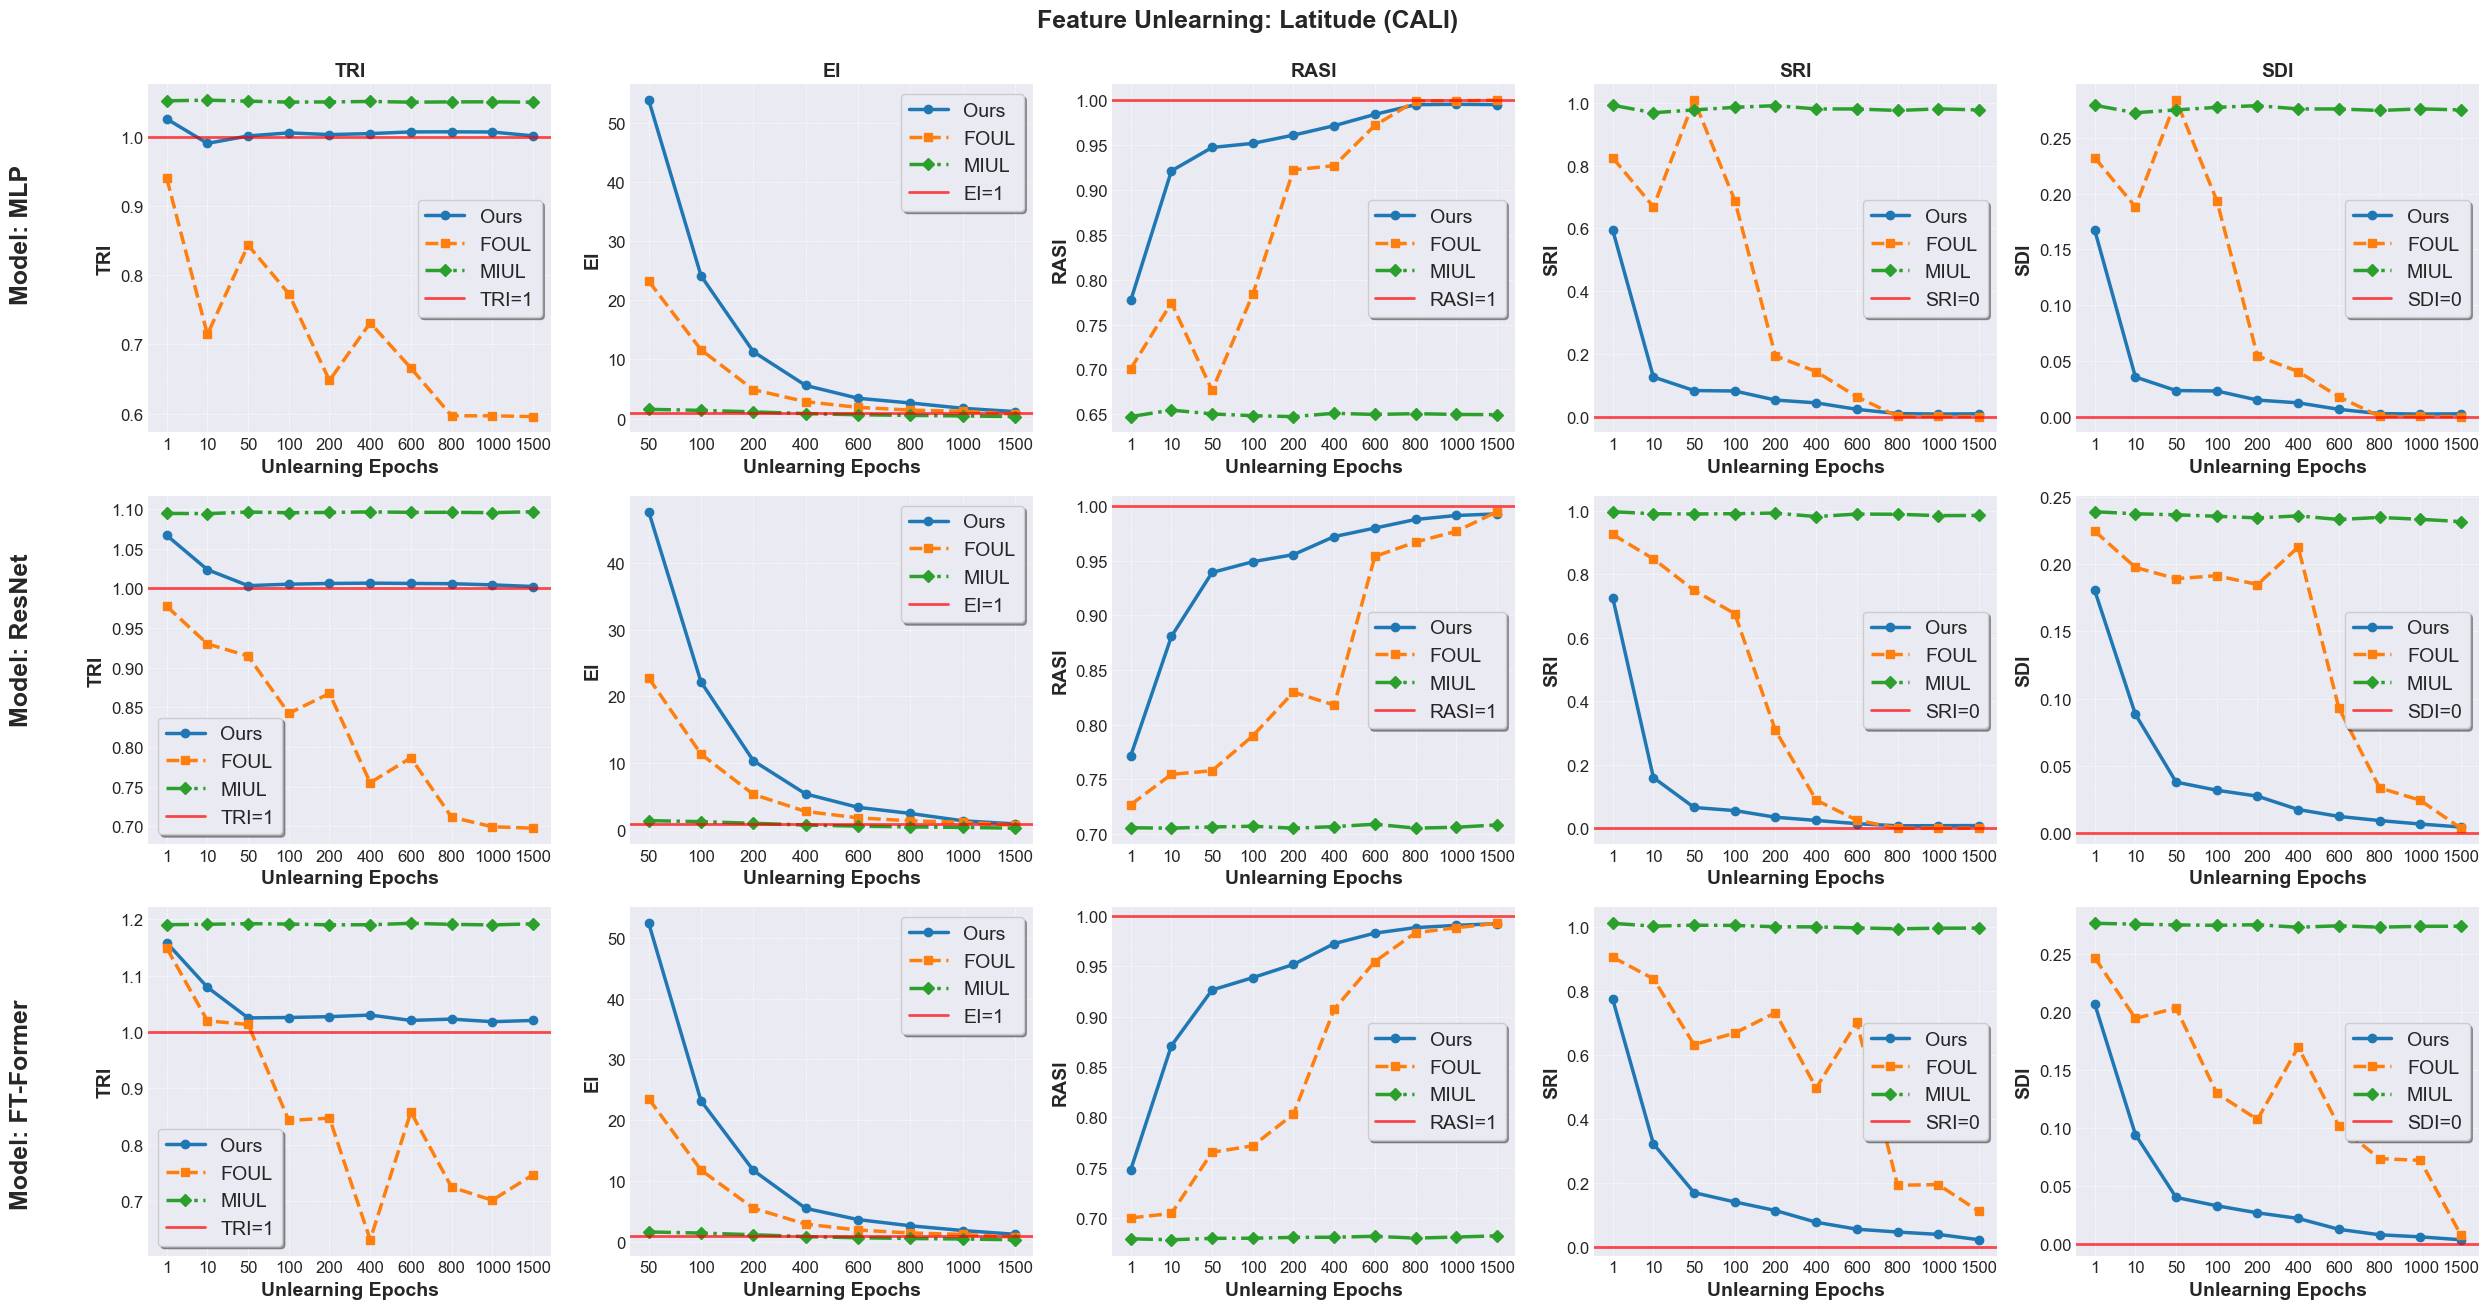

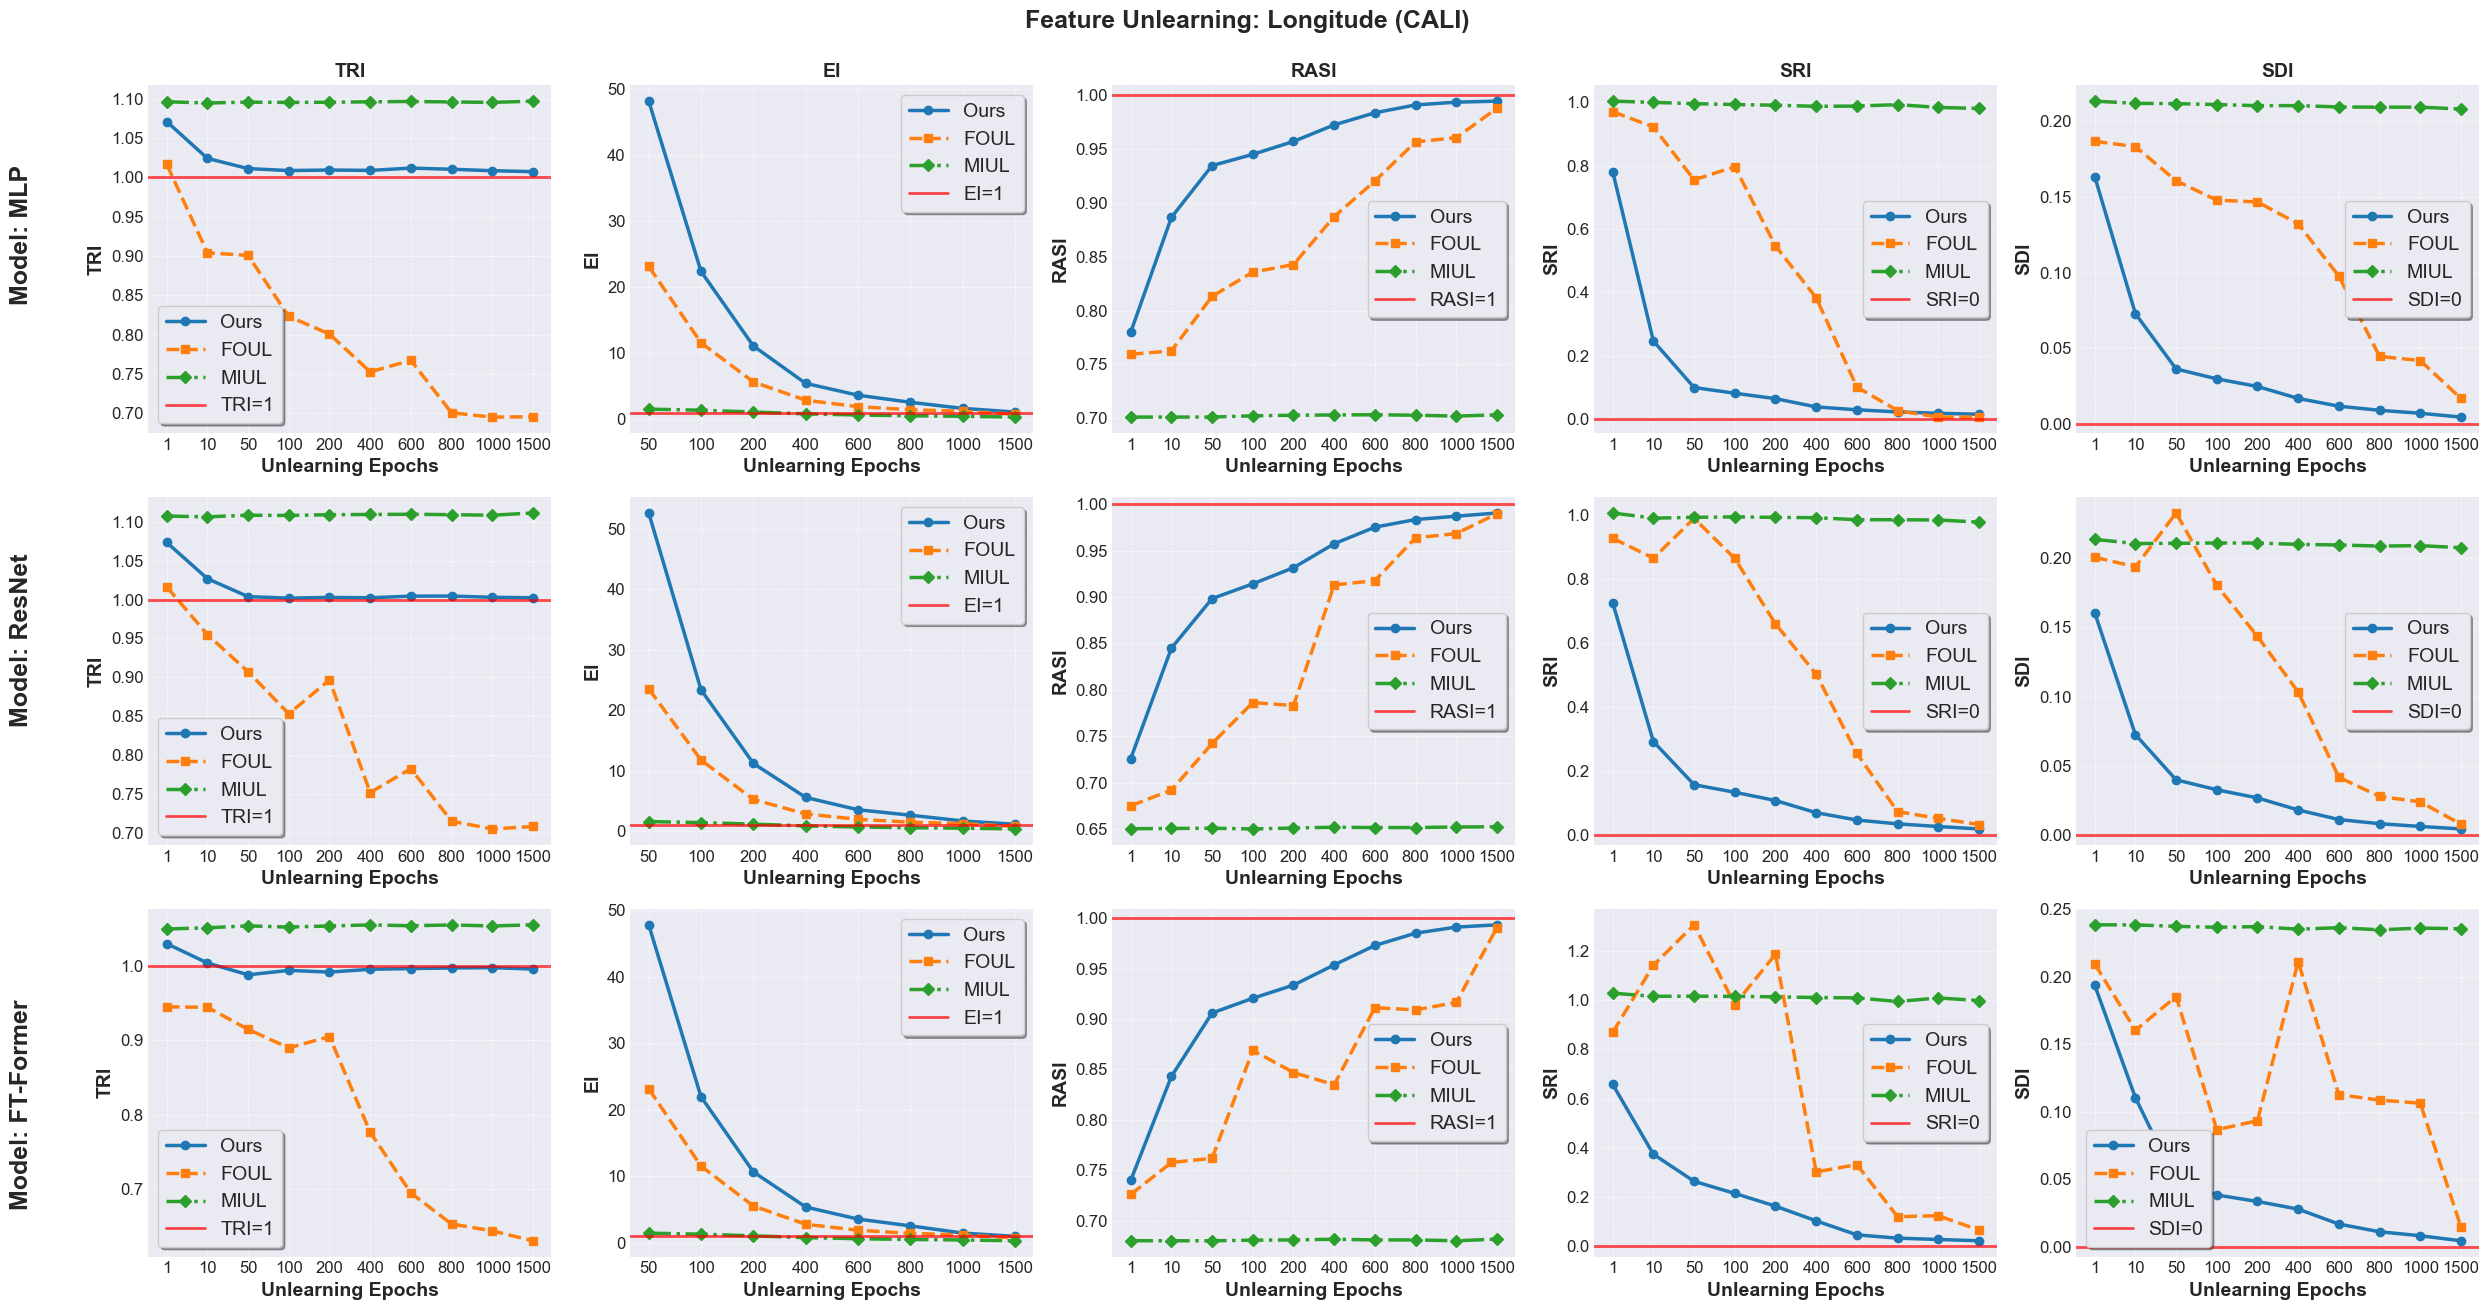

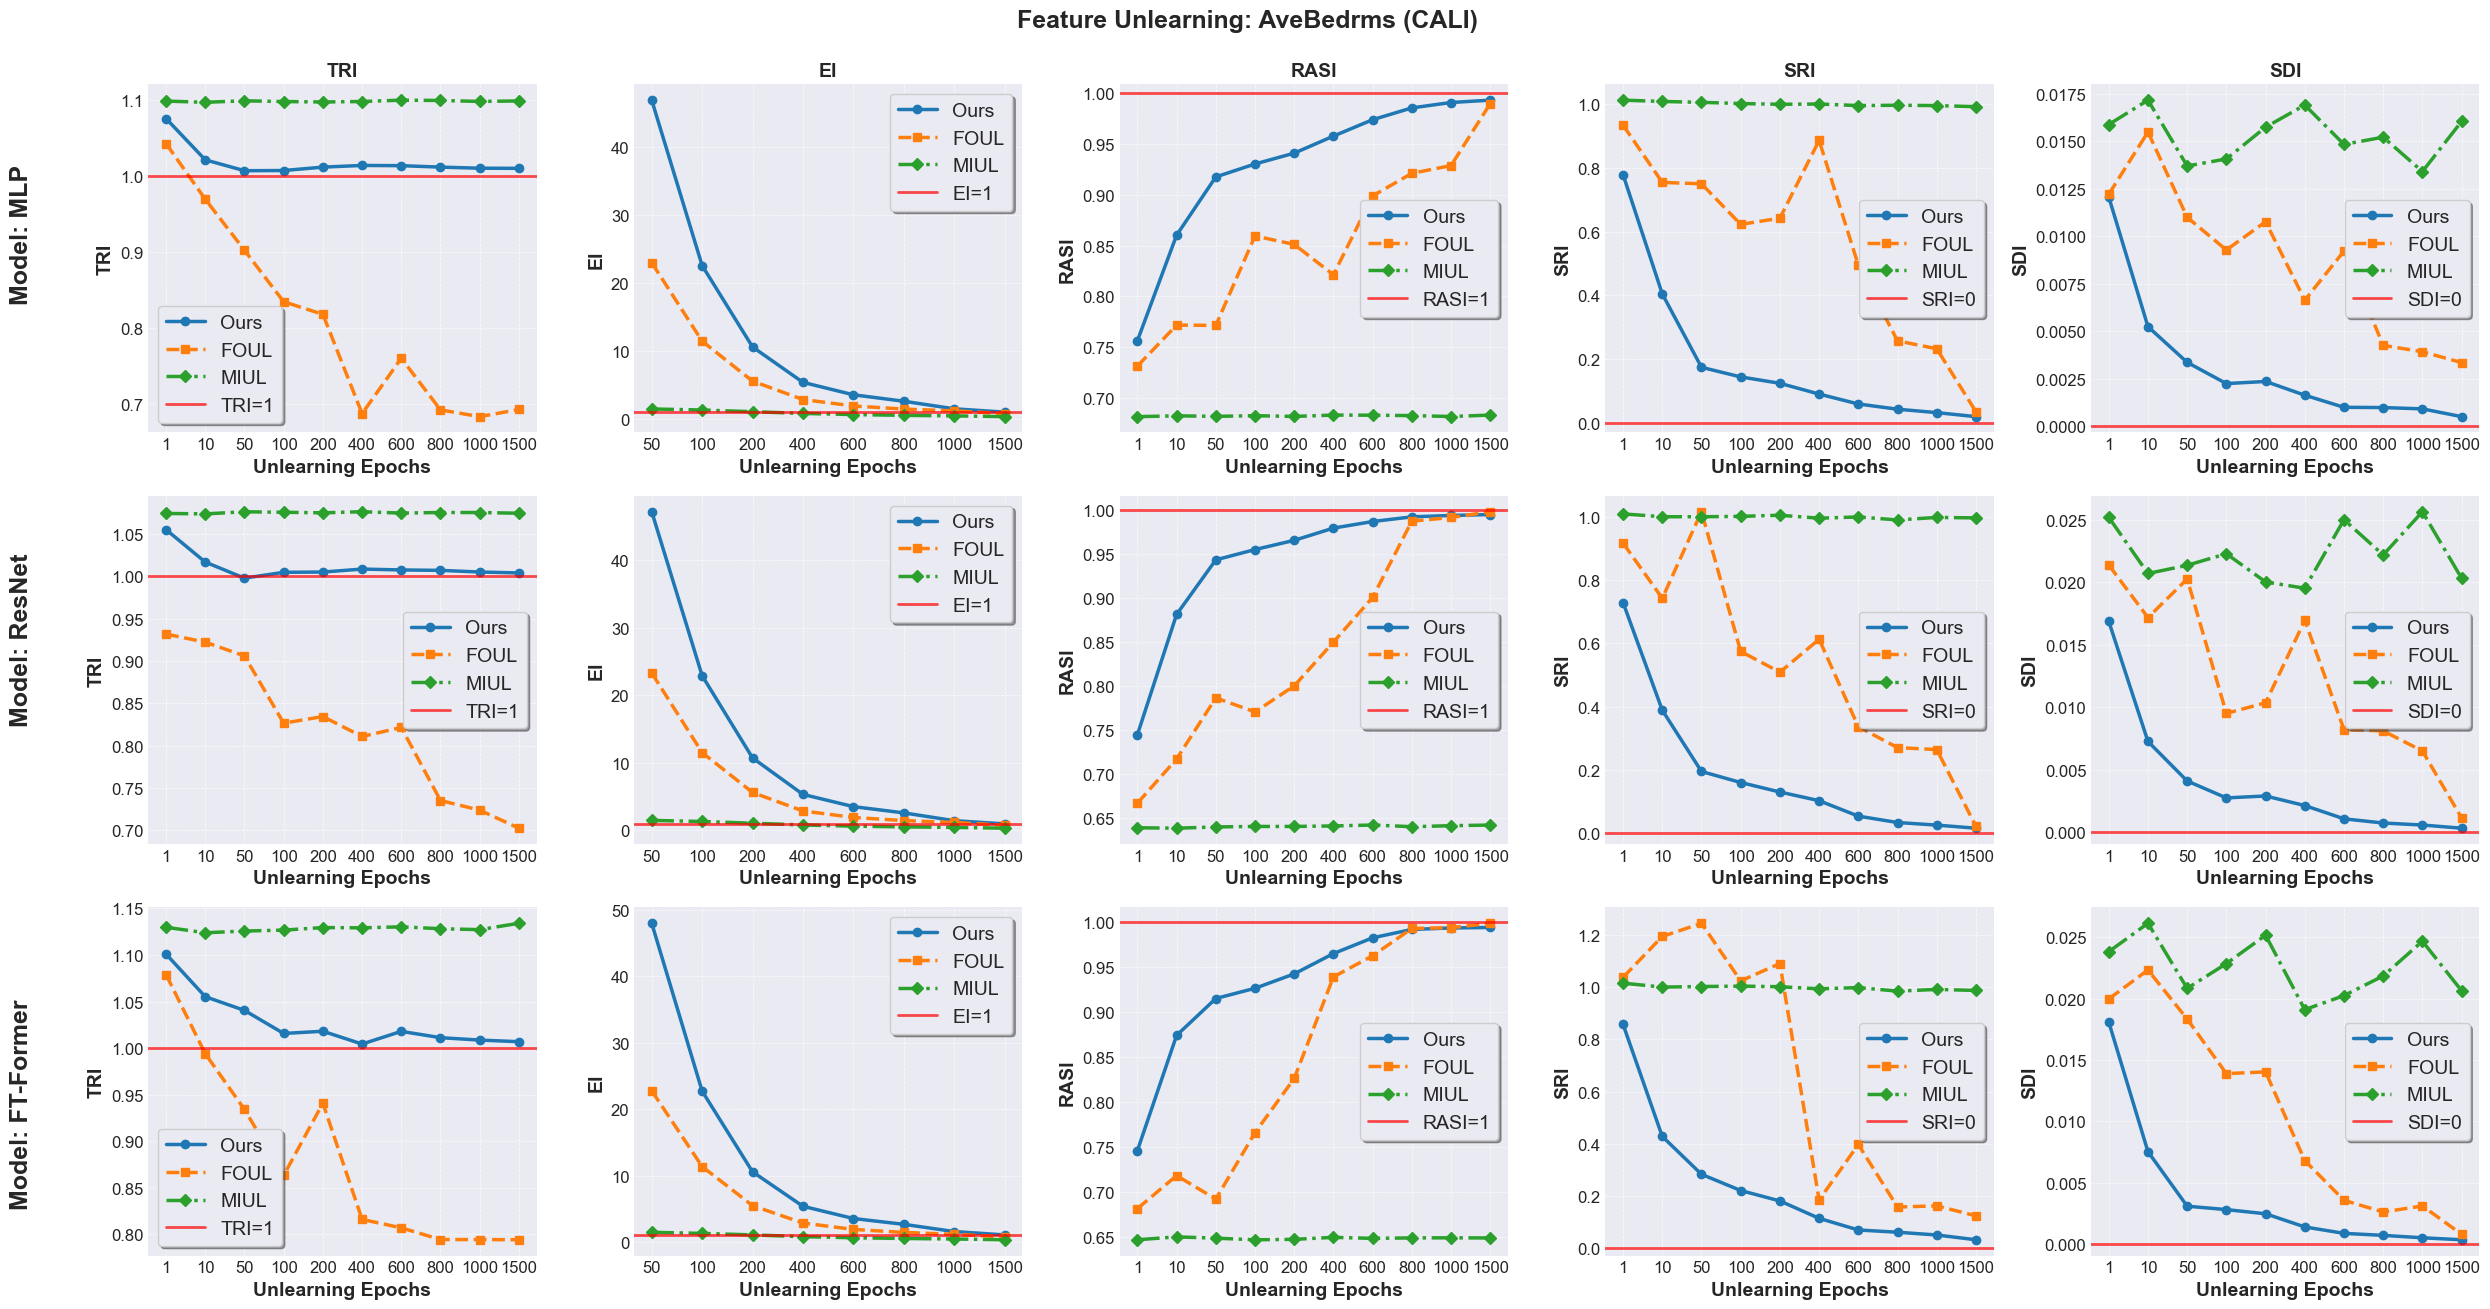

In [6]:
plot_fea_corr(dataset_name='CALI')

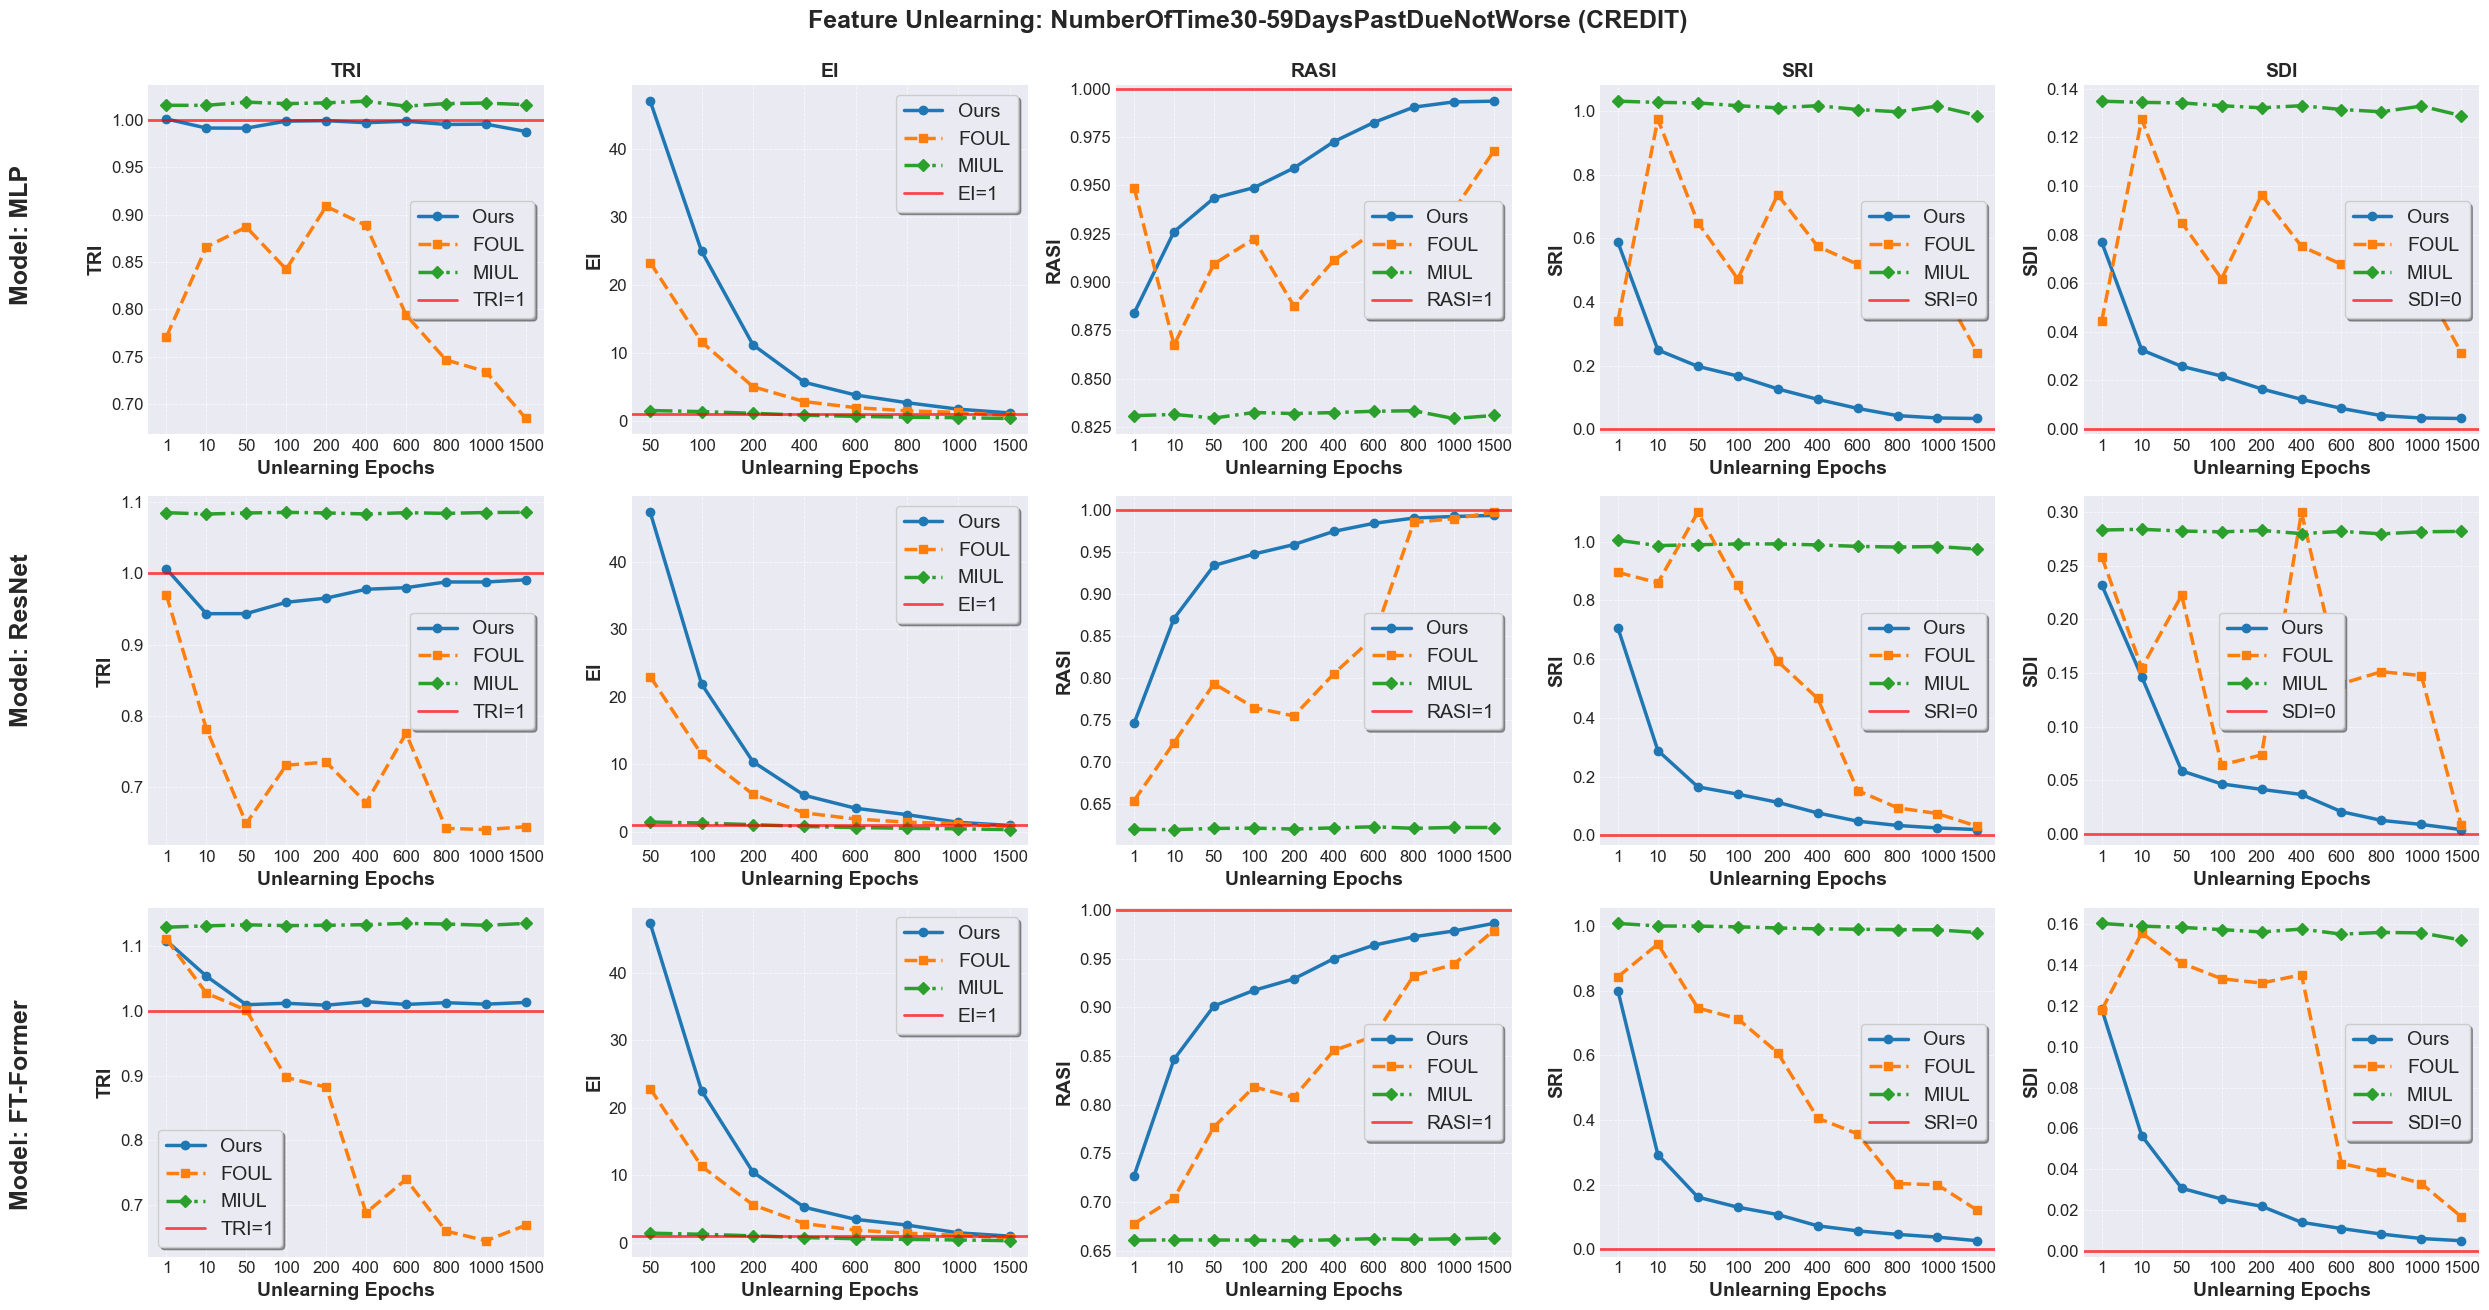

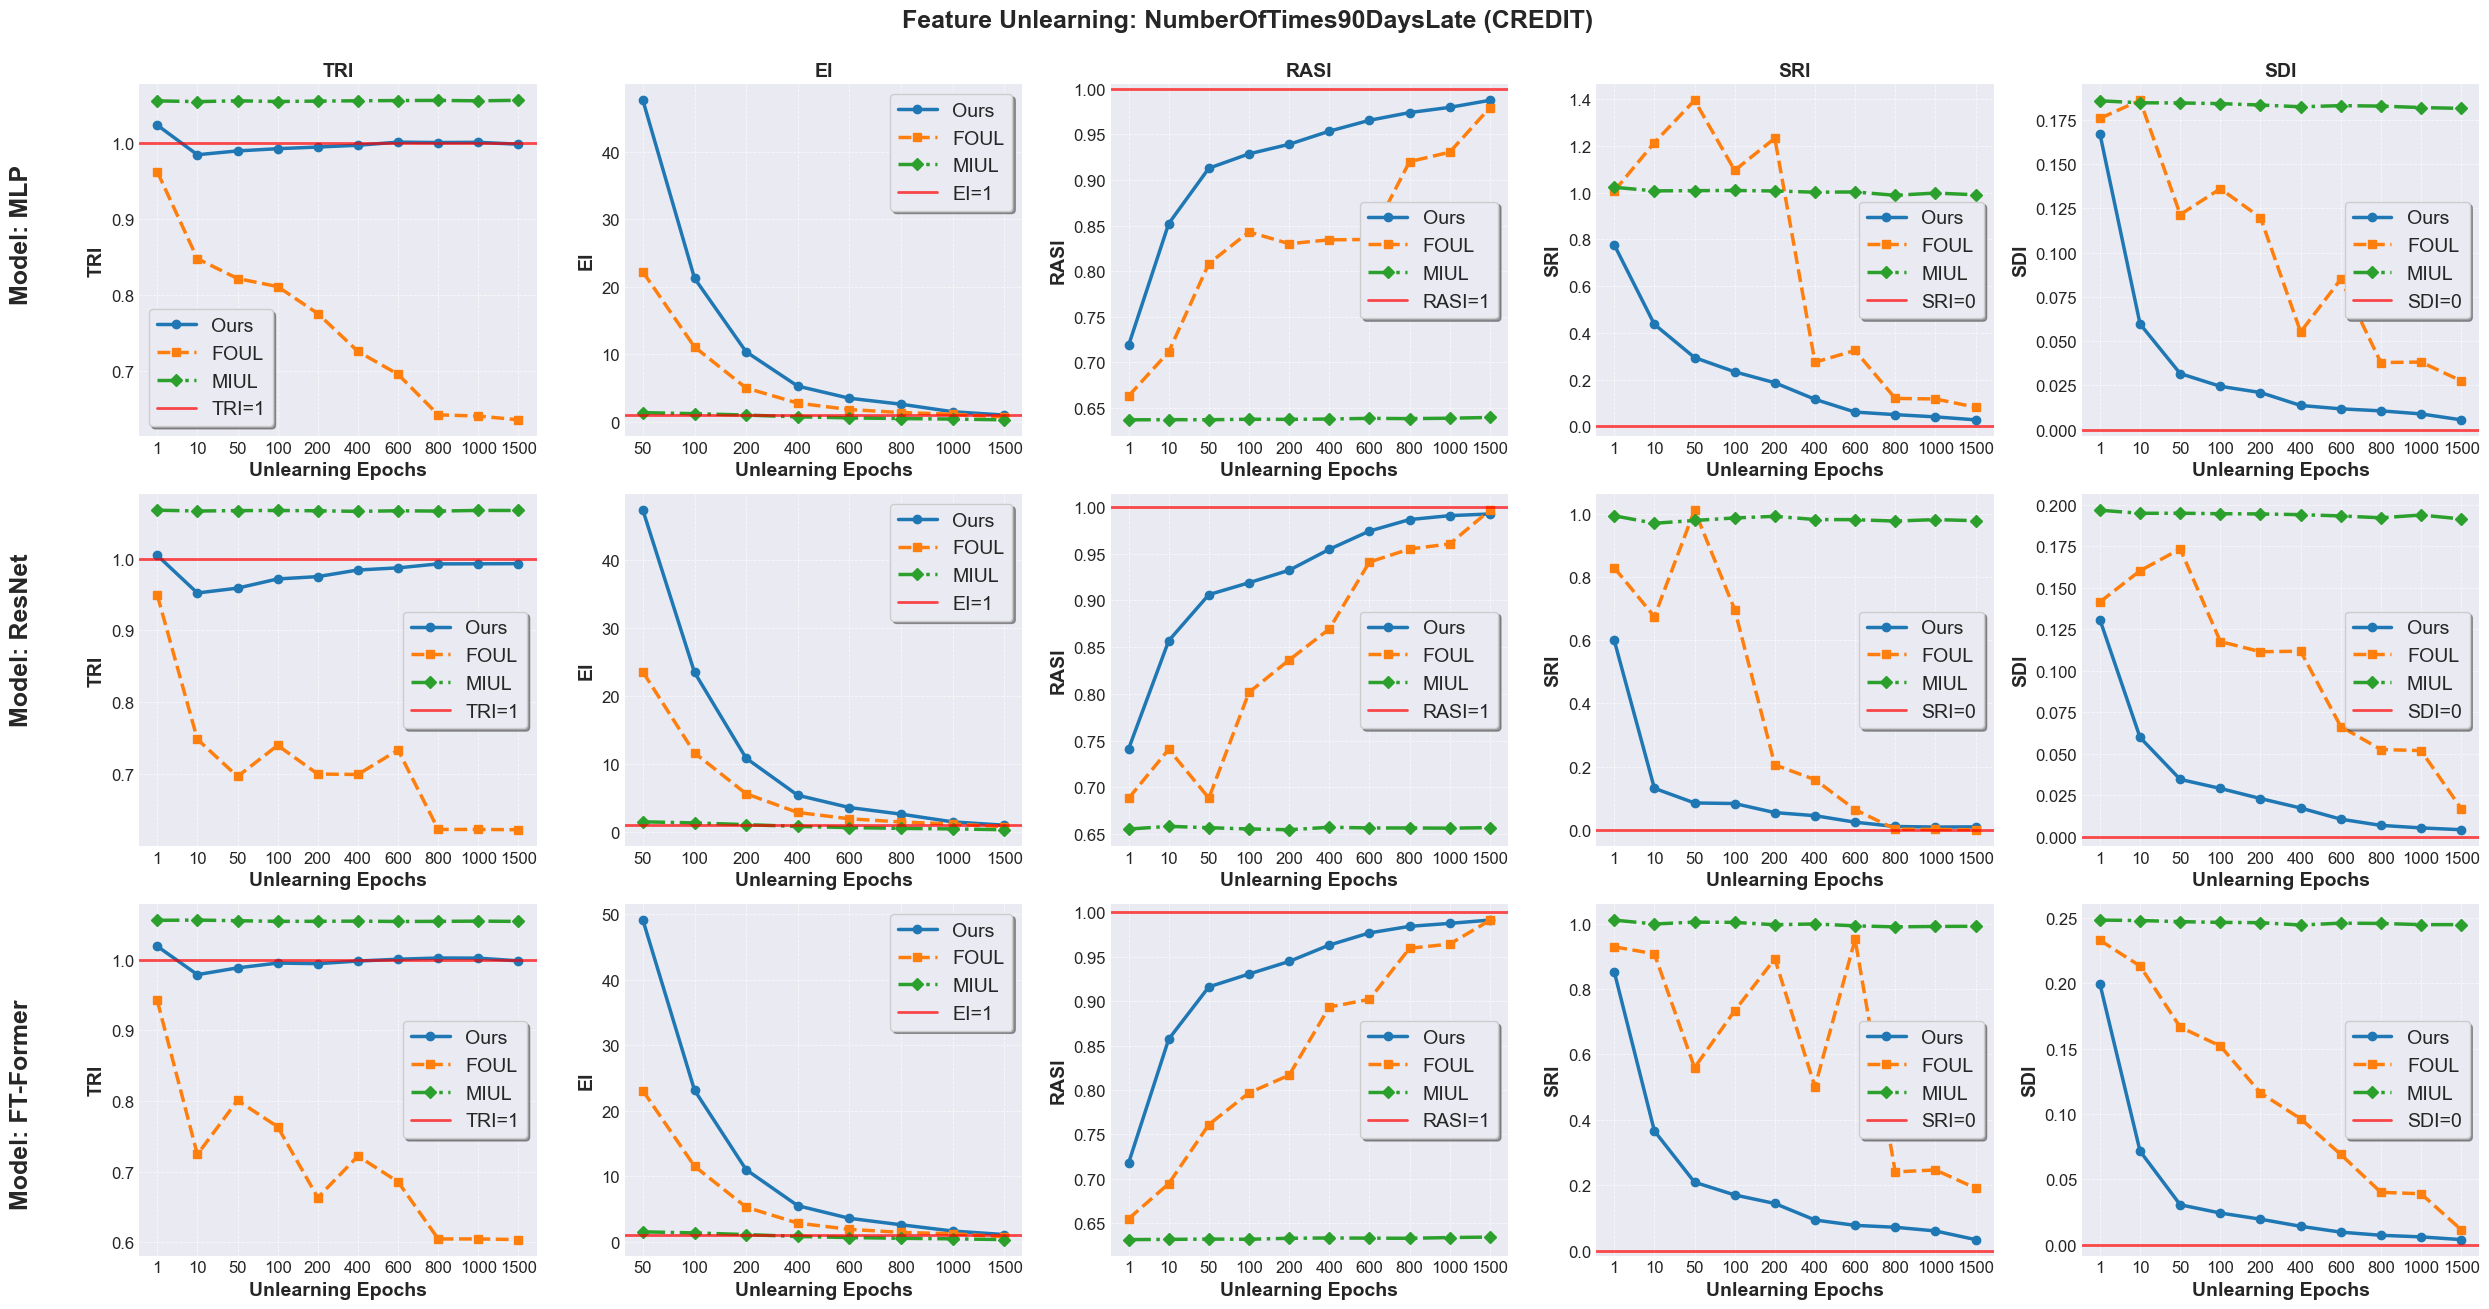

In [7]:
plot_fea_corr(dataset_name='CREDIT')

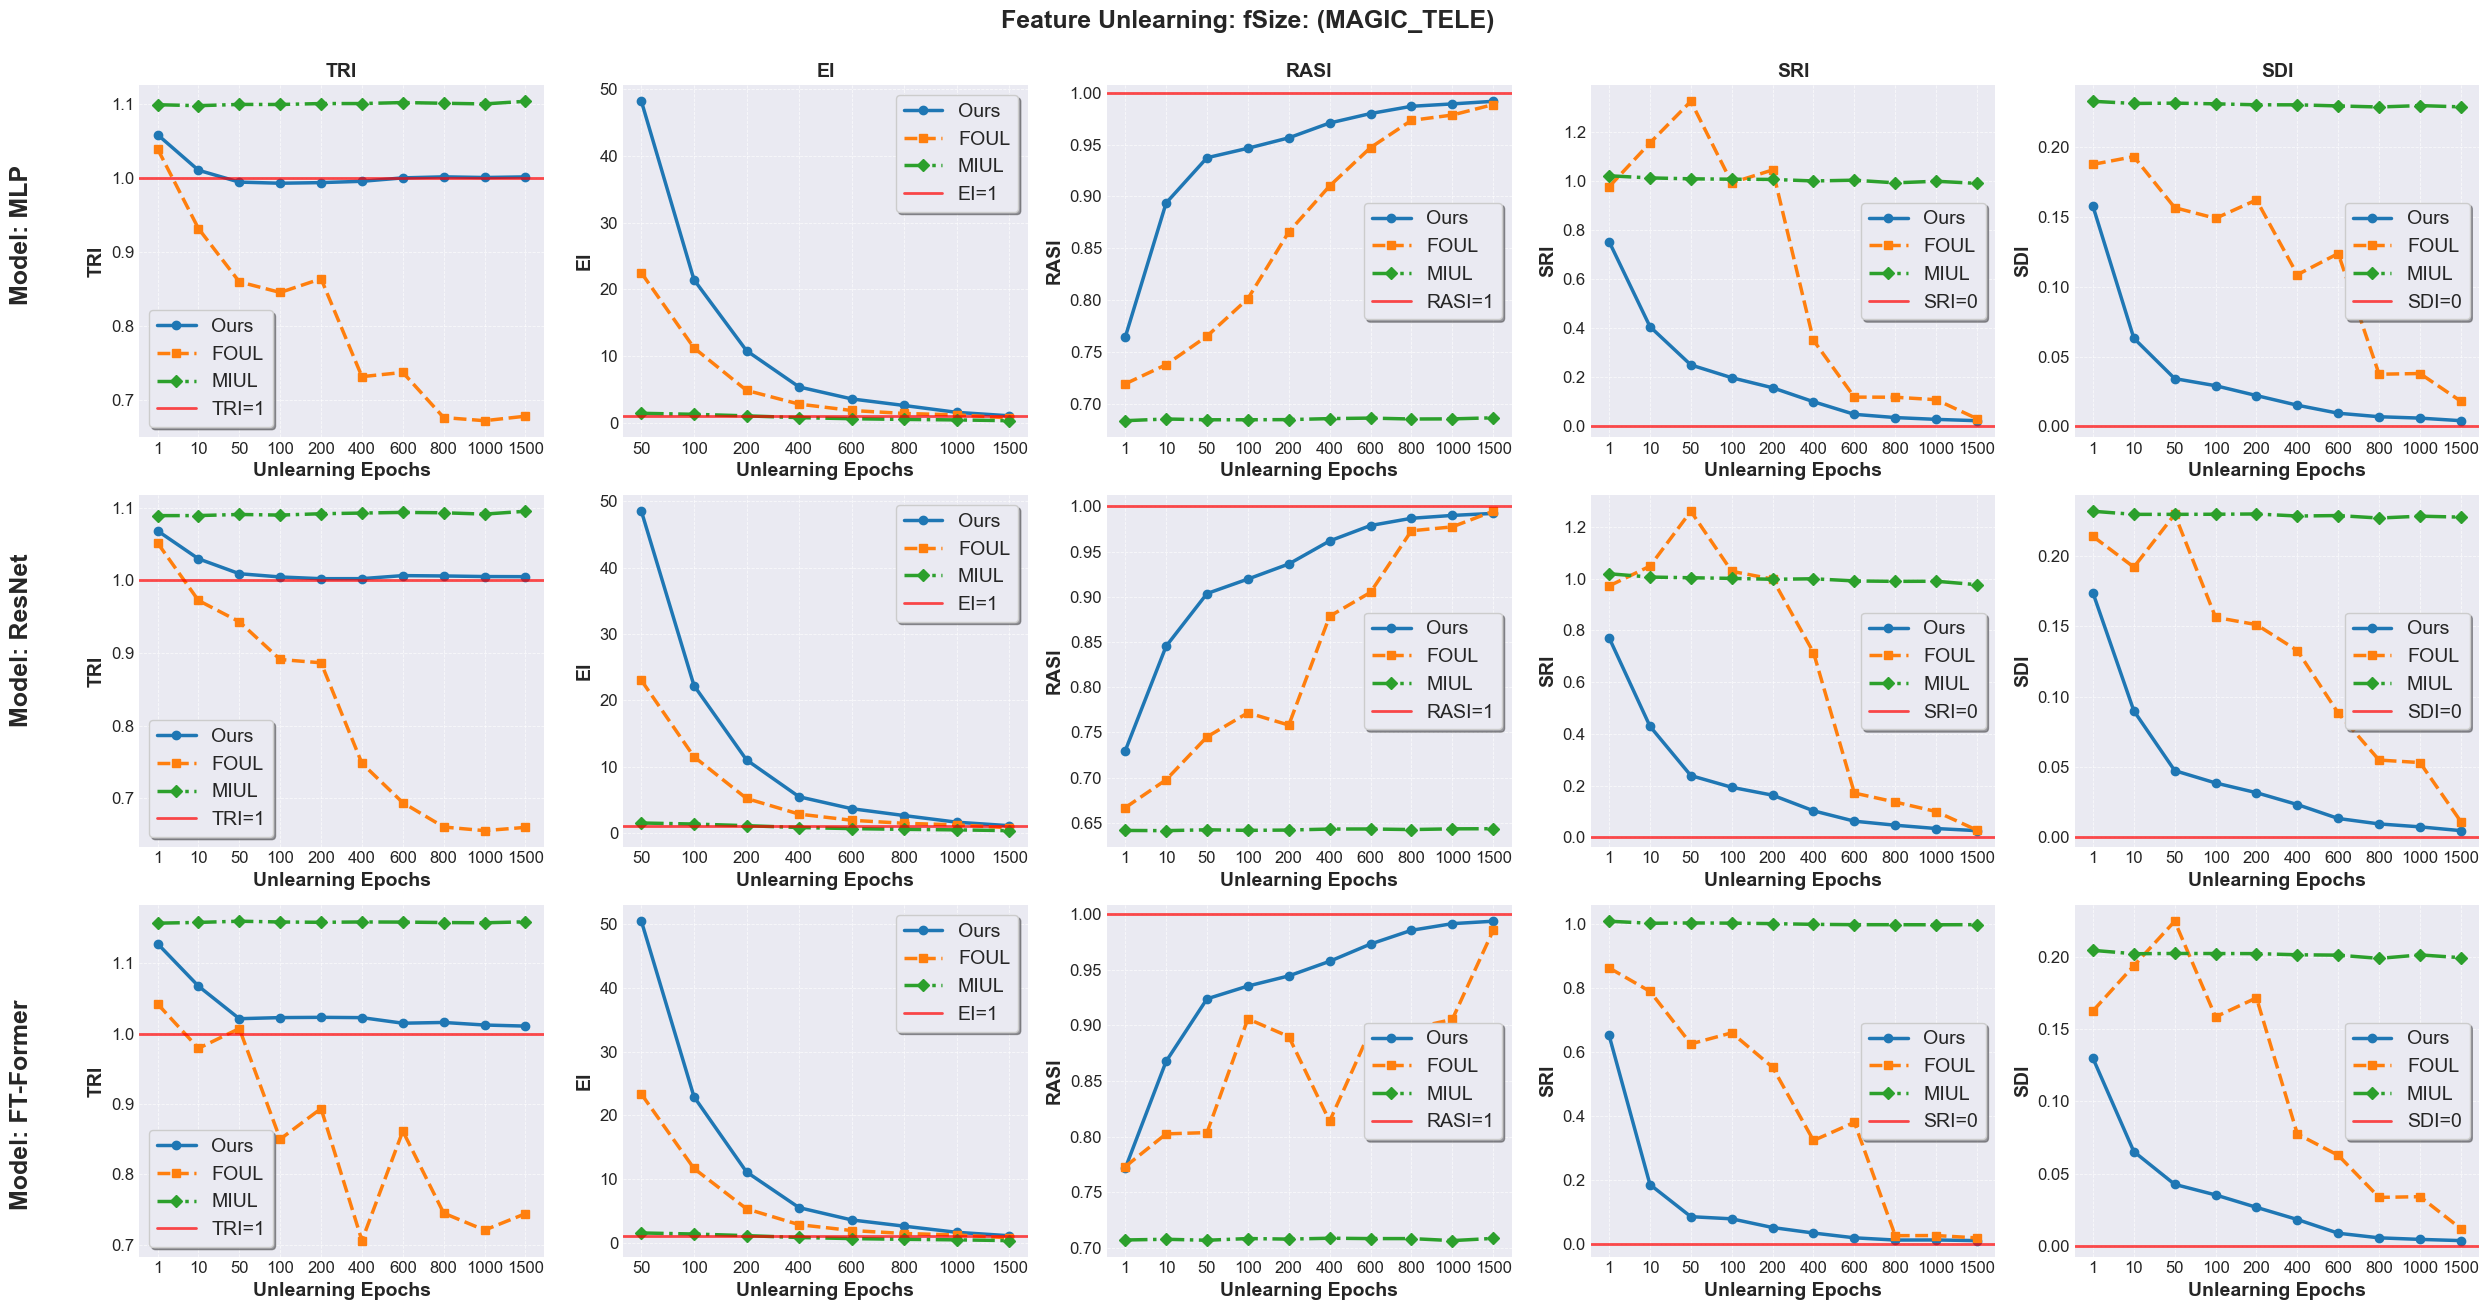

In [8]:
plot_fea_corr(dataset_name='MAGIC_TELE')